## Import packages

In [63]:
from IPython.display import display
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import masw_functions as mf
import os
import subprocess
%matplotlib inline

## Read data

Read the file **header.pkl** with pandas as DataFrame and the file **seismic_data_source_1000.nc** with xarray as DataSet

In [64]:
filenames=["header_new.pkl","seismic_data_source_1000.nc"]
for filename in filenames:
    if os.path.isfile(filename):
        print(filename+" exists.")
    else: 
        url = 'https://filedn.com/lEzjnrJwSG47nSDwzIitUuf'
        folder='/Data/swi_python/'
        command = ['wget', url+folder+filename]
        subprocess.run(command)

header = pd.read_pickle(filenames[0])
seismic_datax= xr.open_dataset(filenames[1])
maxtime=4
seismic_data=seismic_datax.where((seismic_datax.time<=maxtime), drop=True)
seismic_data

header_new.pkl exists.
seismic_data_source_1000.nc exists.


<xarray.Dataset>
Dimensions:  (cdp: 1180, time: 2001, twt: 4001)
Coordinates:
  * twt      (twt) float64 0.0 2.0 4.0 6.0 ... 7.996e+03 7.998e+03 8e+03
  * time     (time) float32 0.0 0.002 0.004 0.006 ... 3.994 3.996 3.998 4.0
  * cdp      (cdp) int32 871637 871638 871639 871640 ... 872814 872815 872816
Data variables:
    data     (cdp, time) float32 26.84 25.84 23.84 29.84 ... 148.7 138.7 120.7
Attributes:
    sample_rate:         2.0
    text:                C 1 CLIENT                        COMPANY           ...
    measurement_system:  m
    source_file:         Niscota_4B.sgy
    percentiles:         [-8.89837605e+02 -8.00424402e+02 -1.07494686e+02  1....

In [65]:
pos_x=np.array(header['ReceiverX']-header['SourceX_new'], dtype='f')
pos_y=np.array(header['ReceiverY']-header['SourceY_new'], dtype='f')
azimuth = np.degrees(np.arctan2(pos_x, pos_y))
ida = np.where(azimuth < 0)
azimuth[ida] = azimuth[ida] + 360
backazimuth = np.mod(azimuth + 180, 360)
offset = np.linalg.norm([pos_x,pos_y], axis=0)  
header['Azimuth']=azimuth
header['Backazimuth']=backazimuth
header['Offset']=offset

In [66]:
source=1000
shot_pos=header[header['EnergySourcePoint']==source]
seismic_data["backazimuth"] = ("backazimuth",  shot_pos['Backazimuth'])
seismic_data["azimuth"] = ("backazimuth",  shot_pos['Azimuth'])
seismic_data["offset"] = ("backazimuth",  shot_pos['Offset'])
seismic_data["recx"] = ("backazimuth",  shot_pos['ReceiverX'])
seismic_data["recy"] = ("backazimuth",  shot_pos['ReceiverY'])
seismic_data["data"] = (("backazimuth", "time"), np.array(seismic_data.data))

In [67]:
dt= seismic_data.sample_rate*1e-3
minof=500
alpha=5e-3
dbaz=30
fmin, fmax = 1,5 
vmin, vmax = 400,3500
#p=np.linspace(1/vmax, 1/vmin, 201)
p=1/np.linspace(vmin,vmax,201)

DispersionAzimuth=[]
for bazi in range(0,345,15):
    print(bazi)
    bazf=bazi+dbaz                  #Limit values of azimuth
    theta = np.linspace(bazi, bazf, 361)
    shot_backazimuth_pos=shot_pos[(shot_pos['Backazimuth']>bazi)&(shot_pos['Backazimuth']<bazf)&(shot_pos['Offset']>minof)]
    data  = seismic_data.where((seismic_data.backazimuth>=bazi)&(seismic_data.backazimuth<bazf)&(seismic_data.offset>minof), drop=True)  #Select traces for the azimuth bin
    [Time,Off]=np.meshgrid(data.time,data.offset)
    Vel = Off/(Time+dt)
    data.data.values = data.data.values*(1+np.tanh(alpha*(Vel-vmin)))*(1+np.tanh(alpha*(vmax-Vel)))

    # Receiver coordinates (assuming rec_x and rec_y are defined)
    rec_x = data.recx-shot_backazimuth_pos['SourceX_new']
    rec_y = data.recy-shot_backazimuth_pos['SourceY_new']

    DispersionAzimuth.append(mf.beamDispersion(data.data.T.values, dt, rec_x, rec_y, p, theta, fmin, fmax, minpeak=0.1))

0
15
30
45
60
75
90
105
120
135
150
165
180
195
210
225
240
255
270
285
300
315
330


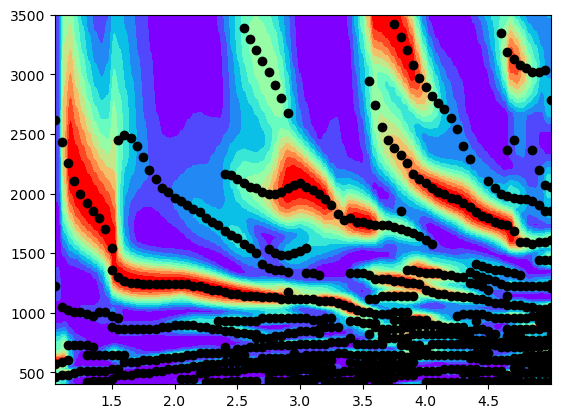

In [79]:
bidx=2
cmap = plt.get_cmap('rainbow', 12)
[Pn, freq, Xobs]=DispersionAzimuth[bidx]
plt.figure()
plt.imshow(Pn, aspect='auto', cmap=cmap, origin='lower', extent=[freq[0], freq[-1], vmin, vmax])
plt.scatter(Xobs[:,0],Xobs[:,1],color='black')
plt.show()

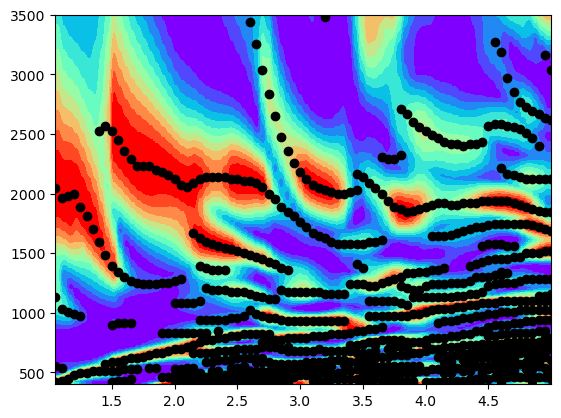

In [77]:
from IPython.display import clear_output, display
import time
fig, ax = plt.subplots()
for bidx in range(len(DispersionAzimuth)):       
    [Pn, freq, Xobs]=DispersionAzimuth[bidx]
    ax.clear()
    ax.imshow(Pn, aspect='auto', cmap=cmap, origin='lower', extent=[freq[0], freq[-1], vmin, vmax])
    ax.scatter(Xobs[:,0],Xobs[:,1],color='black')
    clear_output(wait=True)
    display(fig)
    time.sleep(2.0)
plt.close(fig)

In [70]:
# Save Dispersion Analysis info as .pkl
if 0:
      import pickle
      filedis="dispersion_1000.pkl"
      if os.path.isfile(filedis):
            print(filedis+" exists.")
      else: 
            with open(filedis, 'wb') as f:
                  pickle.dump(DispersionAzimuth, f)